In [52]:
import SimpleITK as sitk 
import os
import numpy as np 
import nrrd
from AIAH_utility.viewer import BasicViewer
from tqdm import tqdm
import pandas as pd
from picai_prep.preprocessing import PreprocessingSettings, Sample
import multiprocessing
import sys
from src.preprocessing.register_and_crop import register_files
from src.preprocessing.prostate_mask import get_segmask
from src.preprocessing.histogram_match import histmatch

import logging
from pathlib import Path
from src.utils import setup_logging
from src.utils import validate_steps
from argparse import Namespace


In [50]:
args = Namespace(

    t2_dir = '/sc-scratch/sc-scratch-cc06-ag-ki-radiologie/prostate_foundation/git_updated/Prostate-Foundation/MIL/data_temp/t2',
    dwi_dir = '/sc-scratch/sc-scratch-cc06-ag-ki-radiologie/prostate_foundation/git_updated/Prostate-Foundation/MIL/data_temp/dwi',
    adc_dir = '/sc-scratch/sc-scratch-cc06-ag-ki-radiologie/prostate_foundation/git_updated/Prostate-Foundation/MIL/data_temp/adc',
    output_dir = '/sc-scratch/sc-scratch-cc06-ag-ki-radiologie/prostate_foundation/git_updated/Prostate-Foundation/MIL/data_temp/',
    margin = 0.2,
    project_dir = '/sc-scratch/sc-scratch-cc06-ag-ki-radiologie/prostate_foundation/git_updated/Prostate-Foundation/MIL/new_folder'

)

register_files(args)


  0%|          | 0/1 [00:01<?, ?it/s]


Namespace(t2_dir='/sc-scratch/sc-scratch-cc06-ag-ki-radiologie/prostate_foundation/git_updated/Prostate-Foundation/MIL/data_temp/t2_registered', dwi_dir='/sc-scratch/sc-scratch-cc06-ag-ki-radiologie/prostate_foundation/git_updated/Prostate-Foundation/MIL/data_temp/DWI_registered', adc_dir='/sc-scratch/sc-scratch-cc06-ag-ki-radiologie/prostate_foundation/git_updated/Prostate-Foundation/MIL/data_temp/ADC_registered', output_dir='/sc-scratch/sc-scratch-cc06-ag-ki-radiologie/prostate_foundation/git_updated/Prostate-Foundation/MIL/data_temp/', margin=0.2, project_dir='/sc-scratch/sc-scratch-cc06-ag-ki-radiologie/prostate_foundation/git_updated/Prostate-Foundation/MIL/new_folder')

In [51]:
get_segmask(args)

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  0%|          | 0/1 [00:03<?, ?it/s]


Namespace(t2_dir='/sc-scratch/sc-scratch-cc06-ag-ki-radiologie/prostate_foundation/git_updated/Prostate-Foundation/MIL/data_temp/t2_registered', dwi_dir='/sc-scratch/sc-scratch-cc06-ag-ki-radiologie/prostate_foundation/git_updated/Prostate-Foundation/MIL/data_temp/DWI_registered', adc_dir='/sc-scratch/sc-scratch-cc06-ag-ki-radiologie/prostate_foundation/git_updated/Prostate-Foundation/MIL/data_temp/ADC_registered', output_dir='/sc-scratch/sc-scratch-cc06-ag-ki-radiologie/prostate_foundation/git_updated/Prostate-Foundation/MIL/data_temp/', margin=0.2, project_dir='/sc-scratch/sc-scratch-cc06-ag-ki-radiologie/prostate_foundation/git_updated/Prostate-Foundation/MIL/new_folder', seg_dir='/sc-scratch/sc-scratch-cc06-ag-ki-radiologie/prostate_foundation/git_updated/Prostate-Foundation/MIL/data_temp/prostate_mask')

In [54]:
histmatch(args)

Namespace(t2_dir='/sc-scratch/sc-scratch-cc06-ag-ki-radiologie/prostate_foundation/git_updated/Prostate-Foundation/MIL/data_temp/t2_histmatched', dwi_dir='/sc-scratch/sc-scratch-cc06-ag-ki-radiologie/prostate_foundation/git_updated/Prostate-Foundation/MIL/data_temp/DWI_histmatched', adc_dir='/sc-scratch/sc-scratch-cc06-ag-ki-radiologie/prostate_foundation/git_updated/Prostate-Foundation/MIL/data_temp/ADC_histmatched', output_dir='/sc-scratch/sc-scratch-cc06-ag-ki-radiologie/prostate_foundation/git_updated/Prostate-Foundation/MIL/data_temp/', margin=0.2, project_dir='/sc-scratch/sc-scratch-cc06-ag-ki-radiologie/prostate_foundation/git_updated/Prostate-Foundation/MIL/new_folder', seg_dir='/sc-scratch/sc-scratch-cc06-ag-ki-radiologie/prostate_foundation/git_updated/Prostate-Foundation/MIL/data_temp/prostate_mask')

In [64]:
args.seg_dir

'/sc-scratch/sc-scratch-cc06-ag-ki-radiologie/prostate_foundation/git_updated/Prostate-Foundation/MIL/data_temp/prostate_mask'

In [66]:
files = os.listdir(args.t2_dir)
file = files[0]

In [71]:
mix_mask = np.ones_like(adc, dtype=np.float32)

In [ ]:
bool_dwi = False
bool_adc = False
mask, _ = nrrd.read(os.path.join(args.seg_dir, file))
dwi, _ = nrrd.read(os.path.join(args.dwi_dir, file))  
adc, _ = nrrd.read(os.path.join(args.adc_dir, file))

nonzero_vals_dwi = dwi[mask > 0]
if len(nonzero_vals_dwi) > 0:
    min_val = nonzero_vals_dwi.min()
    max_val = nonzero_vals_dwi.max()
    heatmap_dwi = np.zeros_like(dwi, dtype=np.float32)
    
    if min_val != max_val:
        heatmap_dwi = (dwi - min_val) / (max_val - min_val)
        masked_heatmap_dwi = np.where(mask > 0, heatmap_dwi, heatmap_dwi[mask>0].min())
    else:
        bool_dwi = True
        
else:
    bool_dwi = True

nonzero_vals_adc = adc[mask > 0]
if len(nonzero_vals_adc) > 0:
    min_val = nonzero_vals_adc.min()
    max_val = nonzero_vals_adc.max()
    heatmap_adc = np.zeros_like(adc, dtype=np.float32)
    
    if min_val != max_val:
        heatmap_adc = (max_val - adc) / (max_val - min_val)
        masked_heatmap_adc = np.where(mask > 0, heatmap_adc, heatmap_adc[mask>0].min())
    else:
        bool_adc = True

else:
    bool_adc = True
    

if bool_dwi:
    mix_mask = masked_heatmap_adc  
if bool_adc:
    mix_mask = masked_heatmap_dwi 
if not bool_dwi and not bool_adc:
    mix_mask = masked_heatmap_dwi * masked_heatmap_adc
else:
    mix_mask = np.zeros_like(adc_np, dtype=np.float32)

mix_mask = (mix_mask - mix_mask.min()) / (mix_mask.max() - mix_mask.min())
args.heatmapdir = os.path.join(args.output_dir, 'heatmaps/')
os.makedirs(args.heatmapdir, exist_ok=True)
nrrd.write(os.path.join(args.heatmapdir, file), mix_mask)



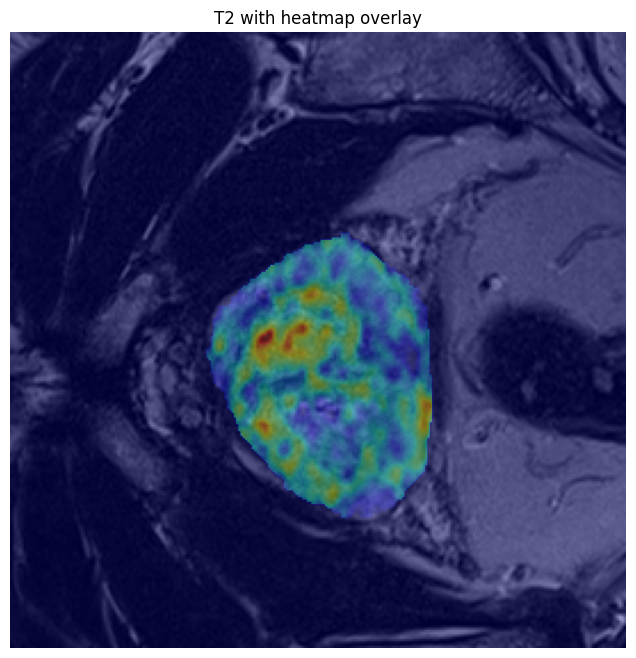

In [69]:
t2, _ = nrrd.read(os.path.join(args.t2_dir, file))
plt.figure(figsize=(8, 8))

plt.imshow(t2[:,:,12], cmap="gray", origin="lower")
plt.imshow(mix_mask[:,:,12], cmap="jet", alpha=0.4, origin="lower")

plt.title("T2 with heatmap overlay")
plt.axis("off")
plt.show()